In [1]:
%matplotlib inline

## Model Inference

Here we show how to load a model for inference

In [2]:
import torch as pt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Models trained with `prehsept` can be loaded as torch script modules:

In [3]:
model = pt.jit.load('../models/gpdk180/nmos-20220617-165140/trace.pt')

For comparison we will load the training data:

In [4]:
df = pd.DataFrame( pt.load('../data/gpdk180-nmos.pt').numpy()
                 , columns = [ "Vg", "W", "L", "M", "temp", "M0.m1:pwr", "M0.m1:vgs"
                             , "M0.m1:vds", "M0.m1:vbs", "M0.m1:vth", "M0.m1:vdsat"
                             , "M0.m1:gm", "M0.m1:gds", "M0.m1:gmbs", "M0.m1:betaeff"
                             , "M0.m1:cgg", "M0.m1:cgd", "M0.m1:cgs", "M0.m1:cgb"
                             , "M0.m1:cdg", "M0.m1:cdd", "M0.m1:cds", "M0.m1:cdb"
                             , "M0.m1:csg", "M0.m1:csd", "M0.m1:css", "M0.m1:csb"
                             , "M0.m1:cbg", "M0.m1:cbd", "M0.m1:cbs", "M0.m1:cbb"
                             , "M0.m1:ron", "M0.m1:id", "M0.m1:gmoverid"
                             , "M0.m1:self_gain", "M0.m1:rout", "M0.m1:fug"
                             , "M0.m1:vearly", "D", "G", "S", "B", "VB:p", "VD:p"
                             , "VG:p", "VS:p" ])

We'll choose a random width ($W$) and length ($L$) from the dataset:

In [5]:
W   = np.random.choice(df.W.unique())
L   = np.random.choice(df.L.unique())
Vdd = np.max(np.abs(df['M0.m1:vds']))

In [6]:
Vbs = round(df['M0.m1:vbs'], ndigits = 2)
Vgs = round(df['M0.m1:vgs'], ndigits = 2)
Vds = round(df['M0.m1:vds'], ndigits = 2)

In [7]:
traces = df[ (df.W == W) & (df.L == L )
           & (df['M0.m1:vbs'] == 0.0) 
           & (df['M0.m1:vds'] == (Vdd / 2.0)) 
           ][['M0.m1:gmoverid', 'M0.m1:fug', 'M0.m1:vds', 'M0.m1:vbs'
             , 'M0.m1:id', 'W', 'L', 'M0.m1:gm', 'M0.m1:gds', 'M0.m1:vgs' ]]

Next we will get the model inputs from the trace as torch tensor:

In [8]:
x = pt.from_numpy(traces[['M0.m1:gmoverid', 'M0.m1:fug', 'M0.m1:vds', 'M0.m1:vbs']].values)

... and feed it through the model

In [9]:
y = model(x)

Now we extract the results and compare them with the original data:

In [10]:
true_gmoverid = (traces['M0.m1:gmoverid']).values
true_idoverw  = (traces['M0.m1:id'] / traces['W']).values
true_gdsoverw = (traces['M0.m1:gds'] / traces['W']).values
true_L        = traces['L'].values

pred_gmoverid = x[:,0].numpy()
pred_idoverw  = y[:,0].numpy()
pred_gdsoverw = y[:,2].numpy()
pred_L_       = y[:,1].numpy()

L_μ           = np.mean(pred_L_)
L_σ           = np.std(pred_L_)
L_hi          = df.L.max()
L_lo          = df.L.min()
pred_L        = np.repeat(L_μ, true_L.size)

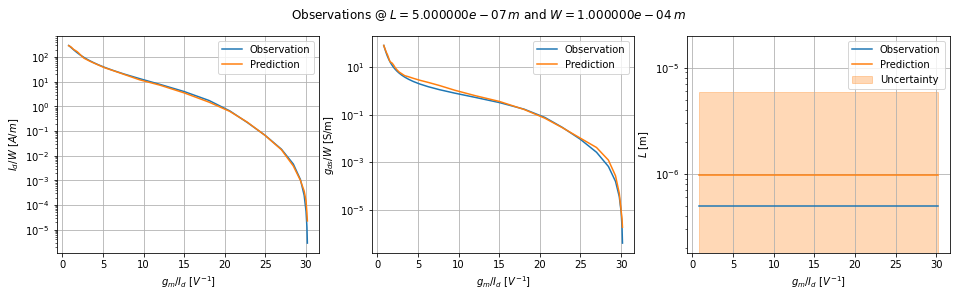

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (16,4))
fig.suptitle(f'Observations @ $L = {L:2e}\,m$ and $W = {W:2e}\,m$')
ax1.plot(true_gmoverid, true_idoverw, label = 'Observation')
ax1.plot(true_gmoverid, pred_idoverw, label = "Prediction")
ax1.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax1.set_ylabel("$I_{d} / W ~ [A/m]$")
ax1.set_yscale("log")
ax1.legend()
ax1.grid("on")
ax2.plot(true_gmoverid, true_gdsoverw, label = "Observation")
ax2.plot(true_gmoverid, pred_gdsoverw, label = "Prediction")
ax2.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax2.set_ylabel("$g_{ds} / W$ [S/m]")
ax2.set_yscale("log")
ax2.legend()
ax2.grid("on")
ax3.plot(true_gmoverid, true_L, label = "Observation")
ax3.plot(true_gmoverid, pred_L, label = "Prediction")
ax3.fill_between( true_gmoverid, (pred_L + (3 * L_σ)), (pred_L - (3 * L_σ))
                , alpha = 0.3, color = "tab:orange", label = "Uncertainty")
ax3.ticklabel_format(axis = 'both', style = 'sci', scilimits = (-2,2))
ax3.set_xlabel("$g_{m} / I_{d} ~ [V^{-1}]$")
ax3.set_ylabel("$L$ [m]")
ax3.set_ylim(L_lo, L_hi)
ax3.set_yscale("log")
ax3.legend()
ax3.grid("on")